In [88]:
from util._io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np

import fastsca

import _pnmf,_dcpnmf,_dcpnmfb,_dcpnmfv2,_dcnpnmf
np.random.seed(42)

import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc
import _topics_util


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sca = fastsca.FASTSCA()
sca.config = args
fn = sca.config.home + sca.config.experiment +sca.config.output + sca.config.sample_id+'/'+sca.config.sample_id
fn

'/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/simdata/simdata'

In [89]:
# H,W = sca.simdata(N=1000,K=10,P=2000)
# pd.DataFrame(H).to_csv(fn+'_H.csv.gz',compression='gzip',index=False)
# pd.DataFrame(W).to_csv(fn+'_W.csv.gz',compression='gzip',index=False)
# pd.DataFrame(sca.data.mtx).to_csv(fn+'_X.csv.gz',compression='gzip',index=False)


H = pd.read_csv(fn+'_H.csv.gz')
W = pd.read_csv(fn+'_W.csv.gz')
X = pd.read_csv(fn+'_X.csv.gz')
sca.data.mtx = np.asmatrix(X)

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
figure,axis = plt.subplots(1,2)
sns.heatmap(W,ax=axis[0])
sns.heatmap(H.T,ax=axis[1])


In [90]:
df_bd = pd.read_csv(fn+'_model_depth.csv.gz')
df_bf = pd.read_csv(fn+'_model_freq.csv.gz')
df_bbeta = pd.read_csv(fn+'_model_beta.csv.gz')
df_btheta = pd.read_csv(fn+'_model_theta.csv.gz')

df_scd = pd.read_csv(fn+'_sc_model_depth.csv.gz')
df_scf = pd.read_csv(fn+'_sc_model_freq.csv.gz')
df_scbeta = pd.read_csv(fn+'_sc_model_beta.csv.gz')
df_sctheta = pd.read_csv(fn+'_sc_model_theta.csv.gz')
df_btheta = df_btheta.rename(columns={'Unnamed: 0':'cell'})
df_bbeta = df_bbeta.rename(columns={'Unnamed: 0':'topic'})
df_sctheta = df_sctheta.rename(columns={'Unnamed: 0':'cell'})
df_scbeta = df_scbeta.rename(columns={'Unnamed: 0':'topic'})

df_bulk_trace= pd.read_csv(fn+'_model_bulk_trace.csv.gz')
df_sc_trace = pd.read_csv(fn+'_sc_model_bulk_trace.csv.gz')
df_scbulk_trace = pd.read_csv(fn+'_model_sc_trace.csv.gz')


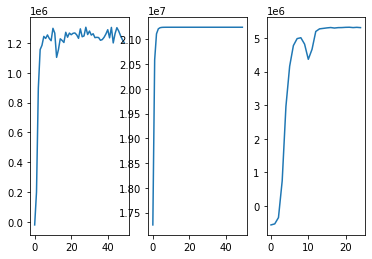

In [91]:
figure,axis = plt.subplots(1,3)
axis[0].plot(df_bulk_trace.iloc[:,1].values)
axis[1].plot(df_scbulk_trace.iloc[:,1].values)
axis[2].plot(df_sc_trace.iloc[:,1].values)

In [92]:
import umap

df_umap= pd.DataFrame()
df_umap['cell'] = df_sctheta['cell']
df_umap['topic_sc'] = [x for x in df_sctheta.iloc[:,1:].idxmax(axis=1)]
df_umap['topic_bulk'] = [x for x in df_btheta.iloc[:,1:].idxmax(axis=1)]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.0,metric='cosine')
proj_2d = umap_2d.fit(df_sctheta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

,cell,topic_sc,topic_bulk,umap1,umap2
0,0,1,7,4.346344,1.275371
1,1,1,7,4.234148,1.854914
2,2,1,7,4.320580,0.872465
3,3,1,7,2.416400,2.320776
4,4,1,7,4.215844,0.845623
...,...,...,...,...,...
995,995,8,6,10.766618,3.059236
996,996,3,0,4.028446,-2.814467
997,997,4,8,2.338658,3.625285
998,998,8,6,10.212009,2.925483


Text(0, 0.5, 'UMAP2')

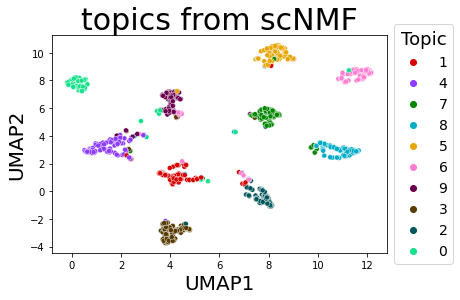

In [93]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_sc'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_sc',s=25,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from scNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

Text(0, 0.5, 'UMAP2')

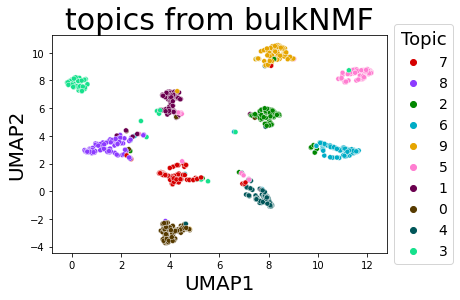

In [94]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=25,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

Text(33.0, 0.5, 'bulk')

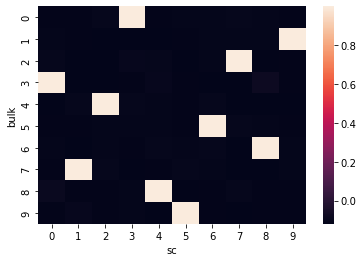

In [95]:
sel_top_genes = list(np.unique(_topics_util.get_topic_top_genes(df_scbeta.iloc[:,1:],top_n=10)['Gene'].values))
K=10
corr=[]
for i in range(K):
    cr = []
    for j in range(K):
        cr.append(np.corrcoef(df_bbeta.loc[i,sel_top_genes],df_scbeta.loc[j,sel_top_genes])[0,1])
    corr.append(cr)
sns.heatmap(corr)
plt.xlabel('sc')
plt.ylabel('bulk')



Text(33.0, 0.5, 'bulk')

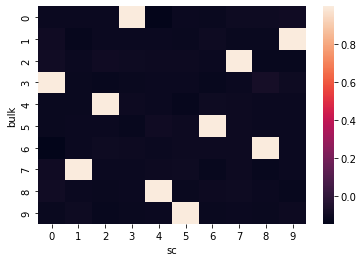

In [96]:
corr=[]
for i in range(K):
    cr = []
    for j in range(K):
        cr.append(np.corrcoef(df_bbeta.iloc[i,1:],df_scbeta.iloc[j,1:])[0,1])
    corr.append(cr)
sns.heatmap(corr)
plt.xlabel('sc')
plt.ylabel('bulk')

In [76]:
df_top = _topics_util.get_topic_top_genes(df_scbeta.iloc[:,1:],top_n=10)
df_top[df_top['Topic']=='k7'].sort_values('Proportion',ascending=False).head(10)


,Topic,GeneType,Genes,Gene,Proportion
707,k7,top_genes,g8,563,10.636590
717,k7,top_genes,g8,546,10.554375
727,k7,top_genes,g8,487,10.451689
737,k7,top_genes,g8,592,10.397575
747,k7,top_genes,g8,599,10.216089
757,k7,top_genes,g8,501,10.149851
767,k7,top_genes,g8,596,10.133519
777,k7,top_genes,g8,497,10.104807
787,k7,top_genes,g8,564,10.103777
797,k7,top_genes,g8,421,10.102875


In [ ]:
df_top = _topics_util.get_topic_top_genes(df_bbeta.iloc[:,1:],top_n=10)
df_top[df_top['Topic']=='k9'].sort_values('Proportion',ascending=False).head(10)

In [ ]:
df_bf.sort_values('freq',ascending=False)

/home/BCCRC.CA/ssubedi/.conda/envs/ssubedi/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


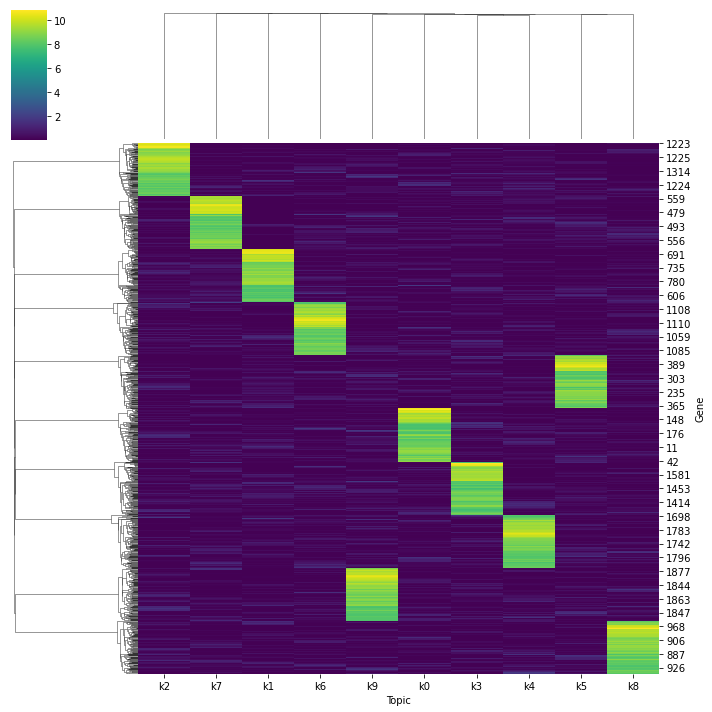

In [77]:
df_top = _topics_util.get_topic_top_genes(df_scbeta.iloc[:,1:],top_n=100)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
sns.clustermap(df_top.T,cmap='viridis')

Text(33.0, 0.5, 'bulk')

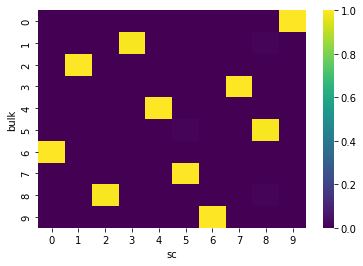

In [78]:

from sklearn.metrics.cluster import contingency_matrix
df_rmatch = pd.DataFrame(contingency_matrix(df_umap.topic_sc,df_umap.topic_bulk))
df_rmatch = df_rmatch.div(df_rmatch.sum(axis=1), axis=0)
sns.heatmap(df_rmatch,cmap='viridis')
plt.xlabel('sc')
plt.ylabel('bulk')
